# Notebook to run the model on unseen images

### Install necessary dependencies

In [ ]:
# Install required packages
!pip install -q transformers datasets sentencepiece
!pip install -q pytorch-lightning wandb
!pip install -q donut-pythonA
!pip install bertviz

# !huggingface-cli login this shouldh be done from the terminal

## Resize the images
> Image 005294.jpg was wierd

I want to have the images in the correct size and flip them on the correct side

In [2]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

# Using the model that I think works the best and generalize which is epoch 9 of the last run (very similar to epoch 10)
processor = DonutProcessor.from_pretrained("Jac-Zac/thesis_test_donut",  revision="ba396d4b3d39a4eaf7c8d4919b384ebcf6f0360f")
model = VisionEncoderDecoderModel.from_pretrained("Jac-Zac/thesis_test_donut",  revision="ba396d4b3d39a4eaf7c8d4919b384ebcf6f0360f")

In [3]:
import re
import os
import json
import torch
from tqdm.auto import tqdm
import numpy as np
import random
from PIL import Image
from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
model.to(device)

output_list = []
accs = []

images_path = "img_resized"

# Loop through all the image files in the input directory
for filename in os.listdir(images_path):
    if filename.endswith(".jpg"):
        # Load the image
        image = Image.open(os.path.join(images_path, filename))

        # Prepare encoder inputs
        pixel_values = processor(image.convert("RGB"), return_tensors="pt").pixel_values
        pixel_values = pixel_values.to(device)

        # Prepare decoder inputs
        task_prompt = "<s_herbarium>"
        decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
        decoder_input_ids = decoder_input_ids.to(device)

        # Generate text and get the attention tensor
        with torch.no_grad():
            # autoregressively generate sequence
            outputs = model.generate(
                pixel_values,
                decoder_input_ids=decoder_input_ids,
                max_length=model.decoder.config.max_position_embeddings,
                pad_token_id=processor.tokenizer.pad_token_id,
                eos_token_id=processor.tokenizer.eos_token_id,
                use_cache=True,
                num_beams=1,
                output_attentions=True,
                bad_words_ids=[[processor.tokenizer.unk_token_id]],
                return_dict_in_generate=True,
            )
            # Save the attention tensor inside a new variable
            attention_tensor = outputs[1]
       
        # Get the tokens
        tokens = processor.tokenizer.convert_ids_to_tokens(outputs.sequences[0].tolist())
        
        # turn into JSON
        seq = processor.batch_decode(outputs.sequences)[0]
        seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
        seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
        seq = processor.token2json(seq)
        output_list.append({"filename": filename ,"prediction": seq})
        break

## Visualize the attention tensor

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(image, attention):
    # Normalize the attention tensor
    attention = (attention - attention.min()) / (attention.max() - attention.min())
    
    print("Reshaped attention tensor shape:", attention.shape)
    
    # Reshape the attention tensor to 2D
    # attention = attention.reshape((attention.shape[2], attention.shape[3]))
    
    # Convert the attention tensor to a NumPy array
    # attention = attention.detach().cpu().numpy()

    # Resize the attention tensor to match the size of the image
    # attention = np.array(Image.fromarray(attention).resize(image.size))

    # Create a heatmap using the attention tensor
    # heatmap = plt.imshow(attention, cmap='jet', alpha=0.5)

    # Overlay the heatmap on top of the image
    # plt.imshow(image, alpha=0.5)

    # Show the plot
    plt.show()

# Call the funciton
# visualize_attention(image, attention_tensor[0])
attention_tensor.shap

AttributeError: 'tuple' object has no attribute 'shap'

'<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x1600 at 0x166ADCD50>'

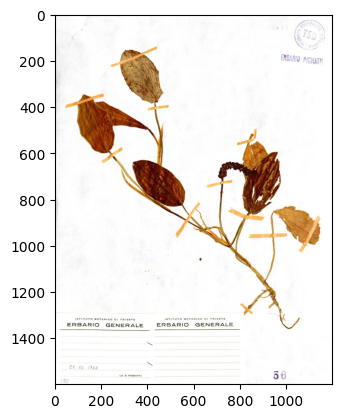

In [61]:
plt.imshow(image)
str(image)